In [191]:
import torch
import os
import numpy as np
import cv2
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import matplotlib
import math
from scipy.stats.kde import gaussian_kde

In [2]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.classes = [0]

Using cache found in C:\Users\grk/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-11-6 Python-3.7.2 torch-1.9.0+cu111 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [3]:
batch_size = 8
image_folder = "dataset/832900"

In [49]:
imgs = [os.path.join(image_folder, i) for i in os.listdir(image_folder)]
img = cv2.imread(imgs[0])
h, w, c = img.shape

In [5]:
results_raw = [model(imgs[i:i+batch_size]) for i in range(0, len(imgs), batch_size)]
results = [torch.cat(i.xyxy, dim=0) for i in results_raw]
results = torch.cat(results, dim=0)

In [6]:
person_boxes = results[:, :4].cpu().numpy()

In [7]:
person_boxes = [] 
persons_cropped = []
for i in results_raw:
    crop_results = i.crop(save=False)
    for j in crop_results:
        person_boxes.append(torch.stack(j['box'], dim=0).cpu().numpy())
        persons_cropped.append(j['im'])
person_boxes = np.array(person_boxes)    

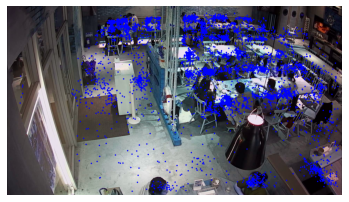

In [192]:
# draw all predictions
%matplotlib inline
centers = np.apply_along_axis((lambda x: (((x[2] + x[0]) / 2), ((x[3] + x[1]) / 2))), 1, person_boxes) 
for point in centers:
    img = cv2.circle(img, (int(point[0]), int(point[1])), radius=4, color=(0, 0, 255), thickness=-1)
plt.axis('off')
plt.imshow(img)

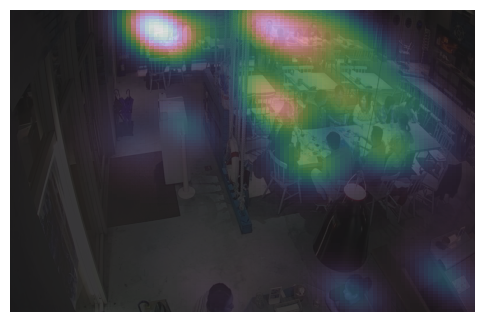

In [190]:
img = cv2.imread(imgs[0])
m1 = centers[:, 0]
m2 = img.shape[0] - centers[:, 1]
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)
fig, ax = plt.subplots()
fig.set_dpi(100)
ax.imshow(np.rot90(Z), cmap=plt.cm.cubehelix,
          extent=[xmin, xmax, ymin, ymax], alpha=0.9)
ax.imshow(im, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto', alpha=0.15)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.axis('off')
plt.show()

In [9]:
import mediapipe as mp
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

In [206]:
def calculateAngle(landmark1, landmark2, landmark3):
    landmark1 = ((landmark1.x), (landmark1.y), (landmark1.z))
    landmark2 = ((landmark2.x), (landmark2.y), (landmark2.z))
    landmark3 = ((landmark3.x), (landmark3.y), (landmark3.z))
    ba = np.array(landmark1) - np.array(landmark2)
    bc = np.array(landmark3) - np.array(landmark2)
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

def classifyPose(landmarks, output_image, display=True):
    label = 'Unknown Pose'
    color = (0, 0, 255)
    if landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].visibility < 0.5 or \
    landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].visibility < 0.5 or \
    landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].visibility < 0.5:
        left_side_angle = 0
    else:
        left_side_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value])
    if landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].visibility < 0.5 or \
    landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].visibility < 0.5 or \
    landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].visibility < 0.5:
        right_side_angle = 0
    else:
        right_side_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value])
    if 50 < left_side_angle < 110 or 50 < right_side_angle < 110:
        label = "Sitting"
    elif 155 < left_side_angle < 215 or 155 < right_side_angle < 215:
        label = "Standing"
    if label != 'Unknown Pose':
        color = (0, 255, 0)  
    cv2.putText(output_image, label, (0, 10),cv2.FONT_HERSHEY_PLAIN, 1, color, 1)
    if display:
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1])
        plt.title("Output Image");
        plt.axis('off');  
        plt.show()
    else:
        return output_image, label

In [207]:
%matplotlib inline
box_labels = []
labeled_images = []
with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.4, model_complexity=1) as pose:
    for image in persons_cropped:
        # Convert the BGR image to RGB and process it with MediaPipe Pose.
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image_height, image_width, _ = image.shape
        if not results.pose_landmarks:
            box_labels.append("Unknown Pose")
            continue
        # Draw pose landmarks.
        annotated_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).copy()
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        
        im, label = classifyPose(results.pose_landmarks.landmark, annotated_image, display=False)
        box_labels.append(label)
        labeled_images.append(im)
        '''
        if label == "Sitting":
            classifyPose(results.pose_landmarks.landmark, annotated_image, display=True)
        '''

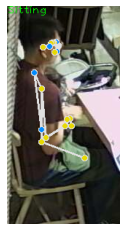

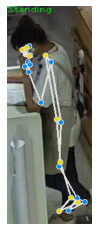

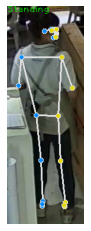

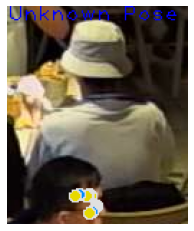

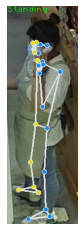

In [244]:
for i in np.random.choice(len(labeled_images), 5):
    plt.imshow(labeled_images[i])
    plt.axis('off')
    plt.show()

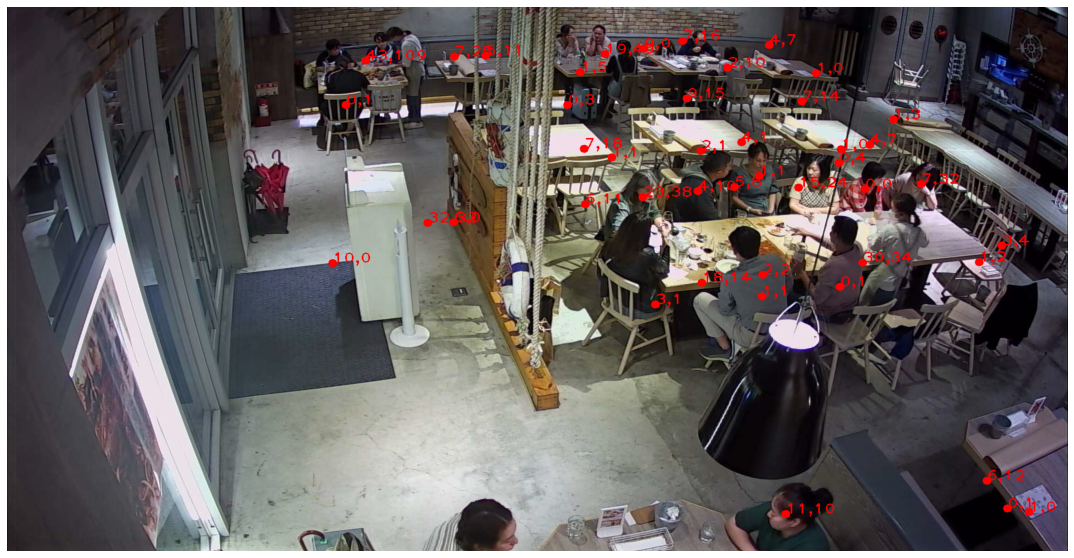

In [259]:
clustering = DBSCAN(eps=15, min_samples=10).fit(centers)
# get centroids
centroids = []
standing_counts = []
sitting_counts = []
cluster_sizes = []
img = cv2.imread(imgs[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
box_labels = np.array(box_labels)
for i in np.unique(clustering.labels_):
    if i == -1:
        continue
    box_labels_cluster = box_labels[clustering.labels_==i]
    standing_count = np.count_nonzero(box_labels_cluster == "Standing")
    sitting_count = np.count_nonzero(box_labels_cluster == "Sitting")
    standing_counts.append(standing_count)
    sitting_counts.append(sitting_count)
    cluster_sizes.append(box_labels_cluster.shape[0])
    points_of_cluster = centers[clustering.labels_==i,:]
    center_point = np.mean(points_of_cluster, axis=0)
    centroids.append(center_point)
    
standing_counts = np.array(standing_counts)
#standing_counts = standing_counts / np.max(standing_counts)
# draw centroids
for i, point in enumerate(centroids):
    img = cv2.circle(img, (int(point[0]), int(point[1])), radius=8, color=(255, 0, 0), thickness=-1)
    cv2.putText(img, "{},{}".format(standing_counts[i], sitting_counts[i]).format(), point.astype(int), cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0), 2)

fig, ax = plt.subplots(figsize=(19, 10))
ax.axis('off')
ax.imshow(img, aspect='auto')

In [260]:
means = []
for i in np.unique(clustering.labels_):
    if i == -1:
        continue
    indices = np.where(clustering.labels_ == i)
    cluster_boxes = person_boxes[indices]
    wh = np.apply_along_axis((lambda x: (((x[2] - x[0])), ((x[3] - x[1])))), 1, cluster_boxes) 
    means.append(np.mean(wh, axis=0))

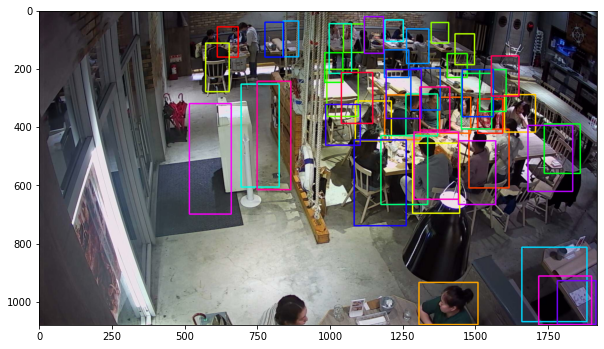

In [261]:
# draw mean boxes around centroids
fig, ax = plt.subplots(figsize=(10,10))
img = cv2.imread(imgs[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cmap = matplotlib.cm.get_cmap('hsv')
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(means))
counter = 0
for centr, wh in zip(centroids, means):
    p1 = (int(centr[0] - wh[0] / 2), int(centr[1] - wh[1] / 2))
    p2 = (int(centr[0] + wh[0] / 2), int(centr[1] + wh[1] / 2))
    color = cmap(norm(counter), bytes=True)[:3]
    img = cv2.rectangle(img, p1, p2, color=tuple(int(x) for x in color), thickness=3)
    counter += 1
plt.imshow(img)